In [2]:
import os
import pandas as pd
import sys
import json
from google.protobuf.json_format import Parse

sys.path.insert(0, 'compiled_protobufs')
from taskmap_pb2 import TaskMap

qrels_folder = os.path.join(os.getcwd(), 'measurements', 'judgments')
run_cooking_folder = os.path.join(os.getcwd(), 'measurements', 'cooking', 'run_files')
# run_diy_folder = os.path.join(os.getcwd(), 'measurements', 'diy', 'run_files')
cooking_runs = os.listdir(run_cooking_folder)
cooking_qrels = os.path.join(qrels_folder, "cooking.qrels")

queries = {
    "COOKING" : pd.read_csv('queries/cooking.csv'),
    "DIY": pd.read_csv('queries/diy.csv'),
}


In [14]:
from results_helper import get_all_metrics, get_all_metrics_searcher

# results = {}
# for searcher in cooking_runs:
#     run = os.path.join(run_cooking_folder, searcher)
#     searcher_name = searcher[:-4].lower()
#     accuracy = get_accuracy(run, cooking_qrles)
#     results[searcher_name] = accuracy
#     # print(searcher_name, accuracy)
# df = pd.DataFrame(results).transpose()
# df
path = "/home/ubuntu/task-search-quality/measurements/cooking/analysis/all-metrics"

get_all_metrics(run_cooking_folder, cooking_qrels, path, with_t5=False)
# get_all_metrics_searcher(run_cooking_folder, cooking_qrels, path, s_name="marqo")

,nDCG@5,R@50,Judged@50,P@5,P@10,Judged@10,P@3,R@20,AP,nDCG@3,nDCG@10,R@10,Judged@20
tct-colbertv2,0.689568,0.442753,0.3938,0.788,0.747,0.969,0.790000,0.299442,0.318965,0.703811,0.658887,0.217558,0.6675
ance,0.654145,0.383478,0.3550,0.746,0.712,0.972,0.783333,0.282487,0.278613,0.679205,0.622192,0.205033,0.6510
bm25+rm3,0.474701,0.359124,0.3930,0.574,0.578,1.000,0.576667,0.237238,0.219197,0.484408,0.474389,0.170735,0.6775
bm25,0.470372,0.369085,0.4058,0.582,0.570,1.000,0.606667,0.248713,0.219119,0.480169,0.464297,0.170634,0.6880
marqo,0.416154,0.250292,0.2842,0.528,0.520,0.995,0.543333,0.187001,0.156307,0.429134,0.413346,0.152461,0.5700


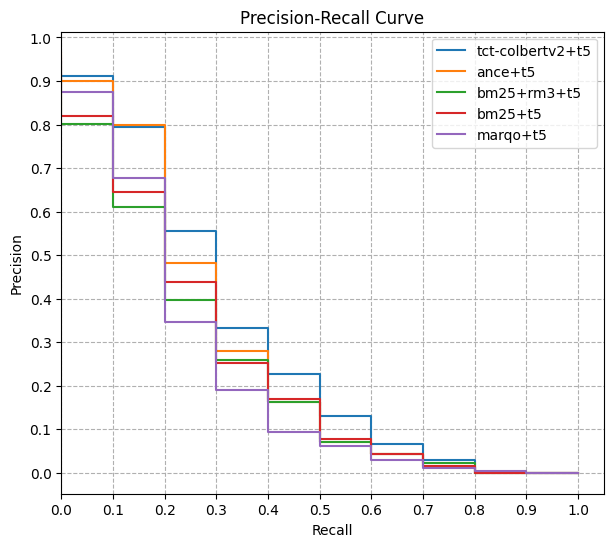

In [12]:
from results_helper import get_precision_recall_graph

get_precision_recall_graph(run_cooking_folder, cooking_qrels, with_t5 = True)

In [19]:
from results_helper import get_metrics, get_raw_query
from ir_measures import *  

queries = pd.read_csv("/home/ubuntu/task-search-quality/queries/cooking.csv")  

t5_vals = [False, True]
for t5 in t5_vals:
    ap_vals = get_metrics(run_cooking_folder, cooking_qrels, AP, t5)
    recall_vals = get_metrics(run_cooking_folder, cooking_qrels, Recall@50, t5)
    ndcg_vals = get_metrics(run_cooking_folder, cooking_qrels, nDCG@10, t5)
    ndcg_vals3 = get_metrics(run_cooking_folder, cooking_qrels, nDCG@3, t5)
    ndcg_vals5 = get_metrics(run_cooking_folder, cooking_qrels, nDCG@5, t5)
    

    results = {}
    results["COOKING"] = {
        "MAP": ap_vals,
        "Recall@50": recall_vals,
        "Ndgc@10": ndcg_vals,
        "Ndgc@3": ndcg_vals3,
        "Ndgc@5": ndcg_vals5,
    }

    analysis_folder = "/home/ubuntu/task-search-quality/measurements/cooking/analysis"
    
    if t5:
        analysis_folder += "/t5-results"
    else:
        analysis_folder += "/non-t5-results"
    if not os.path.exists(analysis_folder):
        os.mkdir(analysis_folder)

    for metric, df in results["COOKING"].items():
        pivoted_df = df.pivot(index='query_id', columns='model', values='metric_val').reset_index()
        pivoted_df["query"] = pivoted_df.apply(lambda x: get_raw_query(x, queries), axis=1)
        pivoted_df.to_csv(os.path.join(analysis_folder, metric+".csv"), index=False)

pivoted_df.head()

model,query_id,TCT-ColBERTv2+t5,ance+t5,bm25+rm3+t5,bm25+t5,marqo+t5,query
0,query-0,0.851630,0.851630,0.773468,0.773468,0.646382,how to spatchcock a turkey
1,query-1,0.330420,0.701224,0.500000,0.458609,0.565603,I want an easy to make dessert for christmas
2,query-10,0.691783,0.808217,0.684352,0.795761,0.650393,recommend some asian street foods
3,query-11,1.000000,0.868795,0.361363,0.084790,0.339160,dinners by batali
4,query-12,0.934397,0.934397,0.065603,0.084790,0.776573,traditional japanese soup


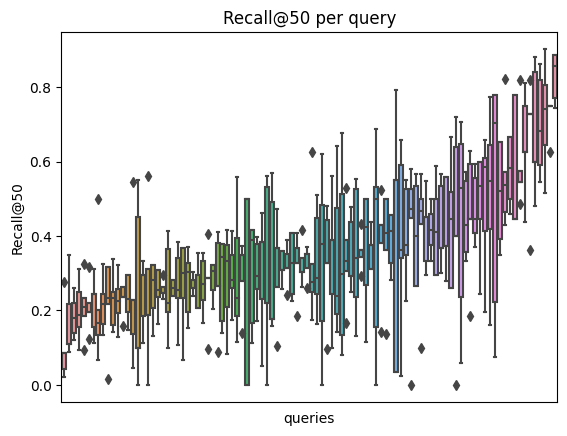

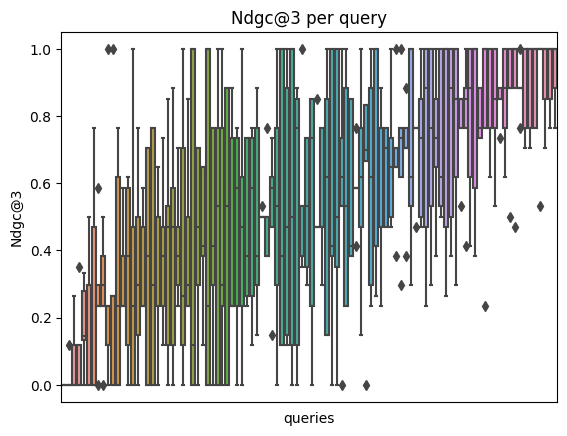

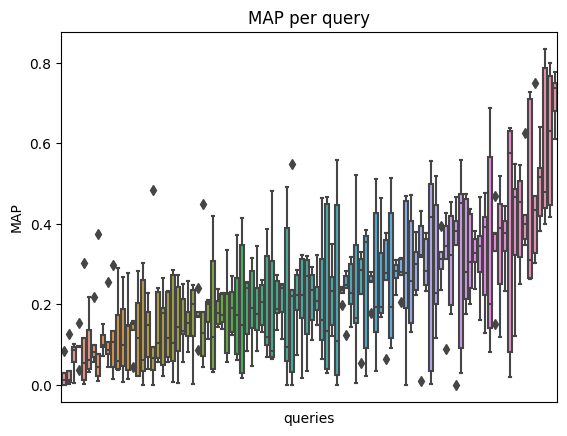

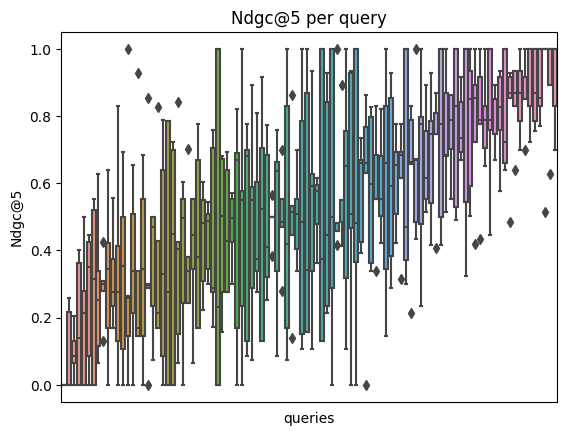

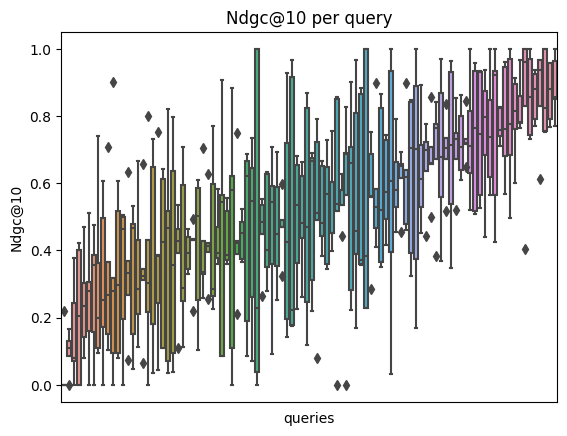

,query_id,TCT-ColBERTv2,ance,bm25,bm25+rm3,marqo,query,mean
71,query-73,0.000000,0.000000,0.000000,0.000000,0.218407,yakamein noodle soup,0.043681
96,query-96,0.085143,0.167253,0.128938,0.110414,0.000000,a grilled filling sandwich,0.098350
42,query-47,0.243102,0.071010,0.378476,0.078398,0.000000,a recipe with a whole chicken,0.154197
87,query-88,0.000000,0.000000,0.204834,0.422575,0.400538,a savory bagel,0.205589
6,query-14,0.304386,0.470485,0.142019,0.078398,0.233690,a romantic dinner,0.245795


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

analysis_folder = "/home/ubuntu/task-search-quality/measurements/cooking/analysis/non-t5-results"

files = os.listdir(analysis_folder)

for file in files:
    
    # print(file)
    filepath = os.path.join(analysis_folder, file)
    df = pd.read_csv(filepath) # index_col="query_id"
    df["mean"] = df.mean(axis=1, numeric_only=True)
    df = df.sort_values(by=["mean"], ascending=True)
    # print(df.columns)
    df_T = df[df.columns[1:-2]].T
    # print(df_T)
    sns.boxplot(data=df_T)
    
    y_label = file.split(".")[0]
    
    plt.title(f"{y_label} per query")
    plt.ylabel(y_label)
    plt.xlabel("queries")
    plt.xticks([])
    plt.show()

df.head()

Ndgc@3.csv
TCT-ColBERTv2    0.102530
ance             0.137199
bm25             0.103175
bm25+rm3         0.028964
marqo            0.000000
mean             0.074374
dtype: float64
MAP.csv
TCT-ColBERTv2    0.057013
ance             0.040558
bm25             0.080885
bm25+rm3         0.058259
marqo            0.085506
mean             0.064444
dtype: float64
Ndgc@5.csv
TCT-ColBERTv2    0.197770
ance             0.220936
bm25             0.111232
bm25+rm3         0.013121
marqo            0.027727
mean             0.114157
dtype: float64
Ndgc@10.csv
TCT-ColBERTv2    0.126526
ance             0.141749
bm25             0.170853
bm25+rm3         0.137957
marqo            0.170527
mean             0.149523
dtype: float64
Ndgc@3.csv
TCT-ColBERTv2    0.133945
ance             0.368599
bm25             0.131196
bm25+rm3         0.126214
marqo            0.082124
mean             0.168416
dtype: float64
MAP.csv
TCT-ColBERTv2    0.109888
ance             0.081383
bm25             0.073651
bm25+r

/tmp/ipykernel_2053/2154698293.py:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


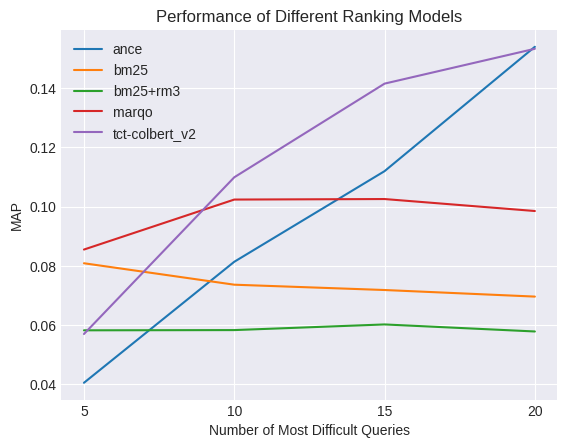

/tmp/ipykernel_2053/2154698293.py:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


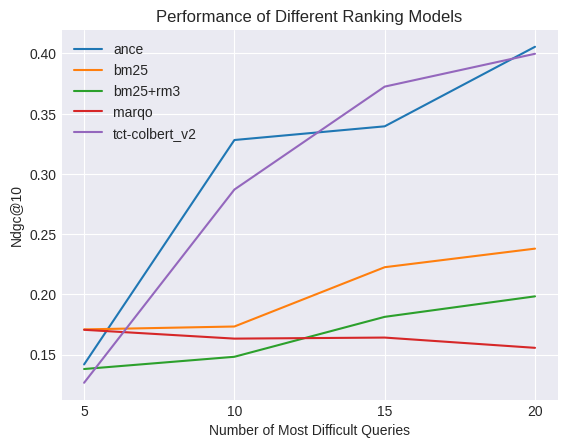

/tmp/ipykernel_2053/2154698293.py:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


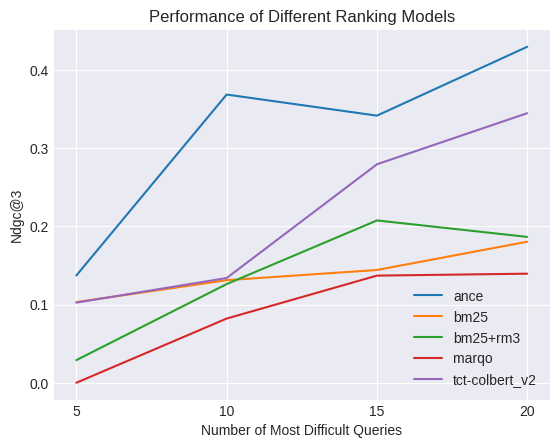

/tmp/ipykernel_2053/2154698293.py:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


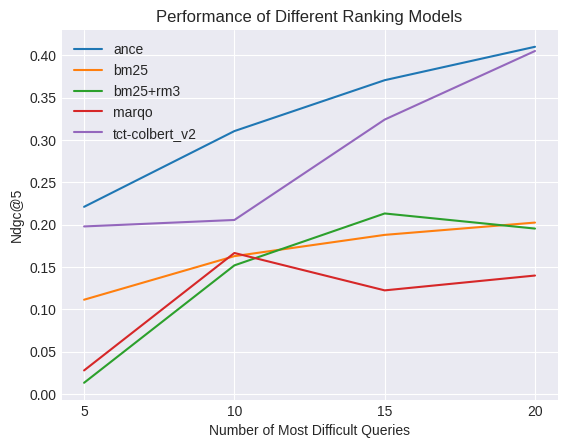

In [21]:
analysis_folder = "/home/ubuntu/task-search-quality/measurements/cooking/analysis/non-t5-results"

files = os.listdir(analysis_folder)

results = {}

thresholds = [5,10, 15,20]

for threshold in thresholds:
    for file in files:
        
        # print(file)
        if "Recall" in file:
            continue
        filepath = os.path.join(analysis_folder, file)
        df = pd.read_csv(filepath) # index_col="query_id"
        df["mean"] = df.mean(axis=1, numeric_only=True)
        df = df.sort_values(by=["mean"], ascending=True)
        hardest_10 = df.head(threshold)
        hardest_10 = hardest_10.drop(columns = ["query_id", "query"])
        hardest_10.mean()
        print(file)
        print(hardest_10.mean())
        results[(threshold, file.split('.')[0])] = hardest_10.mean()


res = []
for threshold, vals in results.items():
        res.append({
            "metric": threshold[1],
            "threshold": threshold[0],
            "ance": vals["ance"],        
            "bm25": vals["bm25"],       
            "bm25+rm3": vals["bm25+rm3"],      
            "marqo": vals["marqo"],        
            "tct-colbert_v2": vals["TCT-ColBERTv2"],        
        })
df_hardest = pd.DataFrame(res)
df_hardest.sort_values(by="metric", inplace=True)
df_hardest.head()


import matplotlib.pyplot as plt

for metric in df_hardest["metric"].unique():
    df = df_hardest[df_hardest["metric"] == metric]
    # set the plot style
    plt.style.use('seaborn-darkgrid')
    # plot the line plot
    for model in df.columns[2:]:
        plt.plot(df["threshold"], df[model], label=model)

    plt.xticks([5, 10, 15, 20])
    plt.ylabel(df["metric"].iloc[0])
    plt.xlabel("Number of Most Difficult Queries")
    # set the title
    plt.title("Performance of Different Ranking Models")
    # add the legend
    plt.legend()
    # show the plot
    plt.show()

/tmp/ipykernel_2053/2781323171.py:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


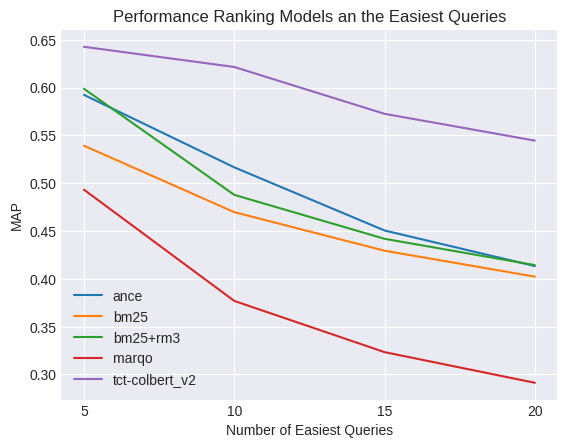

/tmp/ipykernel_2053/2781323171.py:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


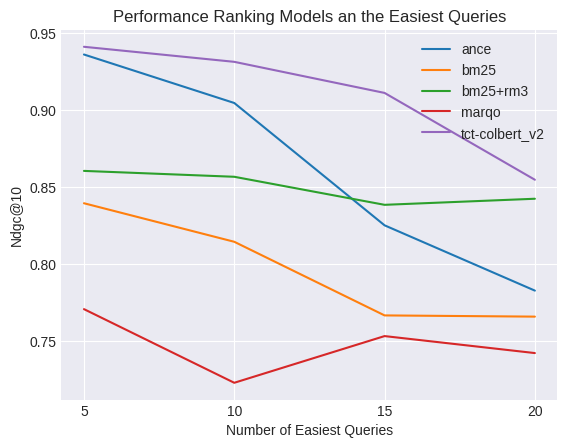

/tmp/ipykernel_2053/2781323171.py:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


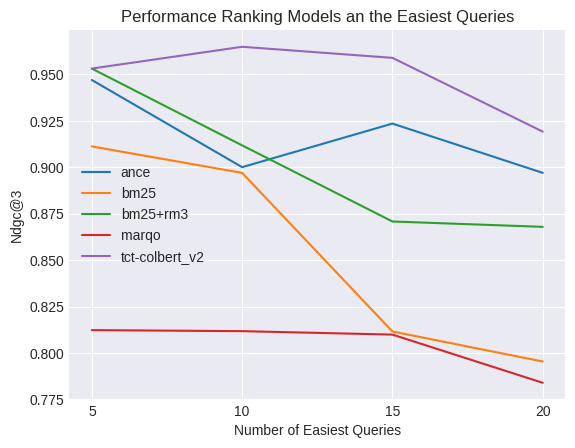

/tmp/ipykernel_2053/2781323171.py:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


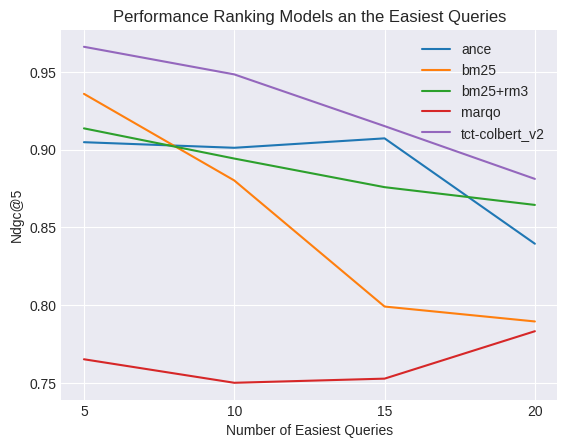

In [22]:
analysis_folder = "/home/ubuntu/task-search-quality/measurements/cooking/analysis/non-t5-results"

files = os.listdir(analysis_folder)

results = {}

# thresholds = range(1,21)
thresholds = [5,10,15,20]

for threshold in thresholds:
    for file in files:
        
        # print(file)
        if "Recall" in file:
            continue
        filepath = os.path.join(analysis_folder, file)
        df = pd.read_csv(filepath) # index_col="query_id"
        df["mean"] = df.mean(axis=1, numeric_only=True)
        df = df.sort_values(by=["mean"], ascending=True)
        easiest = df.tail(threshold)
        easiest = easiest.drop(columns = ["query_id", "query"])
        easiest.mean()
        # print(file)
        # print(easiest.mean())
        results[(threshold, file.split('.')[0])] = easiest.mean()

res = []
for threshold, vals in results.items():
        res.append({
            "metric": threshold[1],
            "threshold": threshold[0],
            "ance": vals["ance"],        
            "bm25": vals["bm25"],       
            "bm25+rm3": vals["bm25+rm3"],      
            "marqo": vals["marqo"],        
            "tct-colbert_v2": vals["TCT-ColBERTv2"],        
        })
df_hardest = pd.DataFrame(res)
df_hardest.sort_values(by="metric", inplace=True)
df_hardest.head()


import matplotlib.pyplot as plt

for metric in df_hardest["metric"].unique():
    df = df_hardest[df_hardest["metric"] == metric]
    # set the plot style
    plt.style.use('seaborn-darkgrid')
    # plot the line plot
    for model in df.columns[2:]:
        plt.plot(df["threshold"], df[model], label=model)

    plt.xticks([5, 10, 15, 20])
    plt.ylabel(df["metric"].iloc[0])
    plt.xlabel("Number of Easiest Queries")
    # set the title
    plt.title("Performance Ranking Models an the Easiest Queries")
    # add the legend
    plt.legend()
    # show the plot
    plt.show()